In [1]:
import json
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext autoreload

%autoreload 2


In [2]:
import profiler
import single_model_profiles as sm_profs

In [3]:
profs = sm_profs.load_single_model_profiles()

In [4]:
profs.keys()

dict_keys(['alexnet', 'res152', 'res18', 'res50', 'inception', 'tf-kernel-svm', 'tf-lang-detect', 'tf-log-reg', 'tf-lstm', 'tf-nmt', 'tf-resnet-feats'])

In [6]:
from IPython.display import display, HTML
display(profs["tf-resnet-feats"])

# aws_profs = res_prof[(res_prof.cloud == "aws")].sort_values("mean_batch_size")
# aws_profs

,num_cpus_per_replica,mean_throughput_qps,std_throughput_qps,p99_latency,mean_batch_size,cost,fname,cloud,gpu_type
0,2,9.252572,0.000473,0.119576,1.000000,0.7950,results-171124_095337.json,aws,k80
1,2,15.658447,0.041688,0.361880,1.909714,0.7950,results-171124_095909.json,aws,k80
2,2,25.644877,0.083090,0.477645,3.919207,0.7950,results-171124_100707.json,aws,k80
3,2,31.679496,0.315383,0.549972,5.788047,0.7950,results-171124_101354.json,aws,k80
4,2,33.885403,0.515985,0.689307,7.771930,0.7950,results-171124_102021.json,aws,k80
5,2,37.219310,0.542419,0.803683,9.907097,0.7950,results-171124_102704.json,aws,k80
6,2,39.519062,0.153764,0.935984,11.968000,0.7950,results-171124_103408.json,aws,k80
7,2,40.359255,0.890720,1.144022,15.142105,0.7950,results-171124_104258.json,aws,k80
8,2,42.993464,0.183316,1.615898,23.384615,0.7950,results-171124_105004.json,aws,k80
9,2,45.814550,1.695242,1.942180,29.890909,0.7950,results-171124_105817.json,aws,k80


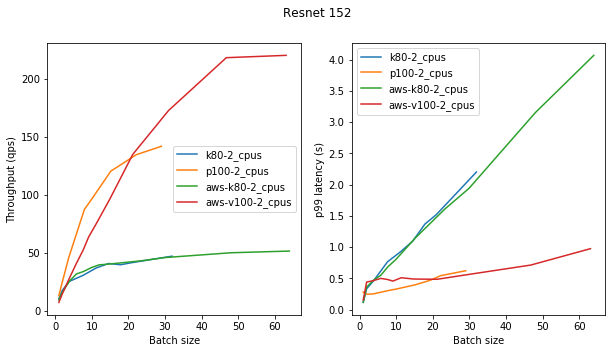

[    num_cpus_per_replica  mean_throughput_qps  std_throughput_qps  \
 21                     2            10.423016            0.005216   
 24                     2            17.559270            0.144581   
 28                     2            25.209698            0.271779   
 29                     2            30.528494            1.039641   
 22                     2            36.818405            1.400797   
 23                     2            40.702688            0.605446   
 25                     2            39.620744            1.258895   
 26                     2            41.430129            1.920641   
 27                     2            47.036489            0.392649   
 
     p99_latency  mean_batch_size   cost                                fname  \
 21     0.116753         1.000000  0.795   results-k80-2-1-171227_225748.json   
 24     0.336443         1.941704  0.795   results-k80-2-2-171227_232703.json   
 28     0.460822         3.796011  0.795   results-k80-

In [8]:
profs = sm_profs.load_single_model_profiles()
def plot_smp_thrus(prof, title, plot_gcp=False, plot_aws=False):
    # GCP
    plt.clf()
    fig, (ax_thru, ax_lat) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    dfs = []
    if plot_gcp:
        gcp_profs = prof[(prof.cloud == "gcp")]
        for gpu in ["k80", "p100"]:
            for num_cpus in [2]:
                df = gcp_profs[(gcp_profs.gpu_type == gpu)
                             & (gcp_profs.num_cpus_per_replica == num_cpus)]
                df = df.sort_values("mean_batch_size")
                ax_thru.plot(df["mean_batch_size"], df["mean_throughput_qps"], label="{gpu}-{cpu}_cpus".format(gpu=gpu, cpu=num_cpus))
                ax_lat.plot(df["mean_batch_size"], df["p99_latency"], label="{gpu}-{cpu}_cpus".format(gpu=gpu, cpu=num_cpus))

                dfs.append(df)
    if plot_aws:
        aws_profs = prof[(prof.cloud == "aws")]
        for gpu in ["k80", "v100"]:
            for num_cpus in [2]:
                df = aws_profs[(aws_profs.gpu_type == gpu)
                              & (aws_profs.num_cpus_per_replica == num_cpus)]
                df = df.sort_values("mean_batch_size")
                ax_thru.plot(df["mean_batch_size"], df["mean_throughput_qps"], label="aws-{gpu}-2_cpus".format(gpu=gpu, cpu=num_cpus))
                ax_lat.plot(df["mean_batch_size"], df["p99_latency"], label="aws-{gpu}-2_cpus".format(gpu=gpu, cpu=num_cpus))

    ax_thru.set_xlabel("Batch size")
    ax_thru.set_ylabel("Throughput (qps)")
    ax_thru.legend(loc=0)
    ax_lat.set_xlabel("Batch size")
    ax_lat.set_ylabel("p99 latency (s)")
    ax_lat.legend(loc=0)
    fig.suptitle(title)
    plt.show()
    return dfs
            
plot_smp_thrus(profs["tf-resnet-feats"], "Resnet 152", plot_gcp=True, plot_aws=True)
# incept_dfs = plot_smp_thrus(profs["inception"], "Inception", plot_gcp=True)

# gcp_results = res_prof[(res_prof.cloud == "gcp") & ()]
# gcp_results

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
for d in incept_dfs:
    display(d)

In [ ]:
def load_results(results_dir):
    fs = os.listdir(results_dir)
    experiments = []
    for exp in fs:
        if exp[-4:] == "json":
            with open(os.path.join(results_dir, exp), "r") as f:
                data = json.load(f)
                experiments.append(data)
        else:
            # print("skipping %s" % os.path.join(results_dir, exp))
            pass
    return experiments

In [ ]:
var_size_results = load_results(
    os.path.abspath("../results/single_model_profs_old/kernel-svm-var-size/"))


mname, df = sm_profs.create_model_profile_df(None, var_size_results)




In [ ]:
df

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
x = np.random.rand(1,4096)
X = np.random.rand(10000,4096)
%timeit k = rbf_kernel(X,x)

In [ ]:
k.dot(x)